In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'AVAX'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-22,4.986754,11.463443,4.125380,5.234632,5.234632,288098840
2020-09-23,5.321654,5.329310,3.982604,4.118469,4.118469,173091214
2020-09-24,3.817925,4.751878,3.539887,4.566561,4.566561,96110964
2020-09-25,4.614028,4.958673,4.240798,4.712279,4.712279,55854397
2020-09-26,4.713736,4.817752,4.376774,4.539249,4.539249,27304546


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-28,38.234318,38.332275,36.560131,36.995396,36.995396,499550168
2024-05-29,36.995396,37.419861,36.127209,36.136925,36.136925,386815665
2024-05-30,36.140000,37.060000,35.330000,35.990000,35.990000,400927205
2024-05-31,35.990000,36.730000,35.220000,36.060000,36.060000,304849133
2024-06-01,36.060000,36.180000,35.700000,35.760000,35.760000,153306282


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

35.76

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.997308,0.996982,0.994692,0.994692,0.712820
High,0.997308,1.000000,0.996257,0.997819,0.997819,0.736341
Low,0.996982,0.996257,1.000000,0.997231,0.997231,0.702890
Close,0.994692,0.997819,0.997231,1.000000,1.000000,0.725008
Adj Close,0.994692,0.997819,0.997231,1.000000,1.000000,0.725008
Volume,0.712820,0.736341,0.702890,0.725008,0.725008,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2020-09-22,5.234632,288098840
2020-09-23,4.118469,173091214
2020-09-24,4.566561,96110964
2020-09-25,4.712279,55854397
2020-09-26,4.539249,27304546
...,...,...
2024-05-28,36.995396,499550168
2024-05-29,36.136925,386815665
2024-05-30,35.990000,400927205


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2020-11-10,3.586142,24316551,3.466072,3.880694,4.003471
2020-11-11,3.484356,24727644,3.446241,3.849648,3.968465
2020-11-12,3.429143,25090677,3.426764,3.814351,3.954678
2020-11-13,3.697801,27584233,3.463269,3.799276,3.937303
2020-11-14,3.500485,24359587,3.494855,3.778380,3.913067


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-28,36.995396,499550168,38.368898,35.926634,36.583021
2024-05-29,36.136925,386815665,38.420407,35.952390,36.376355
2024-05-30,35.990000,400927205,38.005465,36.061842,36.149921
2024-05-31,36.060000,304849133,37.495091,36.154239,35.949969
2024-06-01,35.760000,153306282,37.071848,36.225820,35.876814


<Axes: xlabel='Date'>

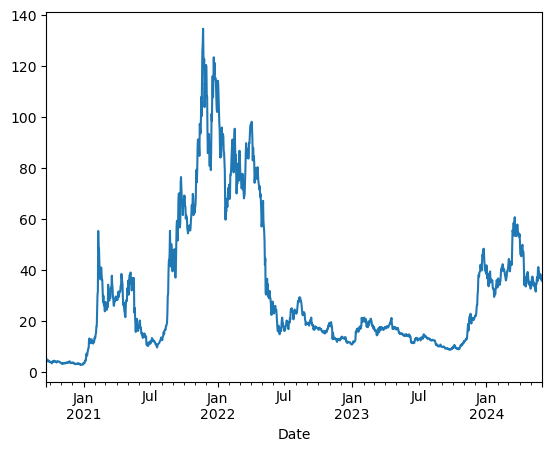

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2020-09-22,5.234632,288098840
1,2020-09-23,4.118469,173091214
2,2020-09-24,4.566561,96110964
3,2020-09-25,4.712279,55854397
4,2020-09-26,4.539249,27304546
...,...,...,...
1344,2024-05-28,36.995396,499550168
1345,2024-05-29,36.136925,386815665
1346,2024-05-30,35.990000,400927205
1347,2024-05-31,36.060000,304849133


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

16:03:11 - cmdstanpy - INFO - Chain [1] start processing
16:03:12 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
1434,2024-08-26
1435,2024-08-27
1436,2024-08-28
1437,2024-08-29
1438,2024-08-30


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1409,2024-08-01,40.184431,17.822445,39.016008,37.275114,43.459333,-11.600954,-11.600954,-11.600954,-0.034083,-0.034083,-0.034083,-11.566871,-11.566871,-11.566871,0.0,0.0,0.0,28.583477
1410,2024-08-02,40.245136,17.870559,40.346855,37.318886,43.594625,-11.527314,-11.527314,-11.527314,-0.059558,-0.059558,-0.059558,-11.467756,-11.467756,-11.467756,0.0,0.0,0.0,28.717822
1411,2024-08-03,40.305841,18.349338,39.915038,37.307185,43.821786,-11.177437,-11.177437,-11.177437,0.161936,0.161936,0.161936,-11.339373,-11.339373,-11.339373,0.0,0.0,0.0,29.128404
1412,2024-08-04,40.366546,18.828661,39.553707,37.299599,43.966637,-11.239906,-11.239906,-11.239906,-0.056963,-0.056963,-0.056963,-11.182943,-11.182943,-11.182943,0.0,0.0,0.0,29.126640
1413,2024-08-05,40.427251,18.655187,40.339628,37.305356,44.126363,-11.089696,-11.089696,-11.089696,-0.089336,-0.089336,-0.089336,-11.000360,-11.000360,-11.000360,0.0,0.0,0.0,29.337556
1414,2024-08-06,40.487956,20.068176,40.533293,37.303761,44.274884,-10.859538,-10.859538,-10.859538,-0.065405,-0.065405,-0.065405,-10.794133,-10.794133,-10.794133,0.0,0.0,0.0,29.628418
1415,2024-08-07,40.548661,19.257748,40.974320,37.231122,44.425364,-10.423913,-10.423913,-10.423913,0.143409,0.143409,0.143409,-10.567322,-10.567322,-10.567322,0.0,0.0,0.0,30.124749
1416,2024-08-08,40.609366,19.949679,40.571889,37.197627,44.576446,-10.357530,-10.357530,-10.357530,-0.034083,-0.034083,-0.034083,-10.323447,-10.323447,-10.323447,0.0,0.0,0.0,30.251836
1417,2024-08-09,40.670071,19.589281,41.741484,37.106496,44.807193,-10.125958,-10.125958,-10.125958,-0.059558,-0.059558,-0.059558,-10.066400,-10.066400,-10.066400,0.0,0.0,0.0,30.544113
1418,2024-08-10,40.730776,20.493290,42.704339,37.033002,44.929392,-9.638394,-9.638394,-9.638394,0.161936,0.161936,0.161936,-9.800330,-9.800330,-9.800330,0.0,0.0,0.0,31.092382


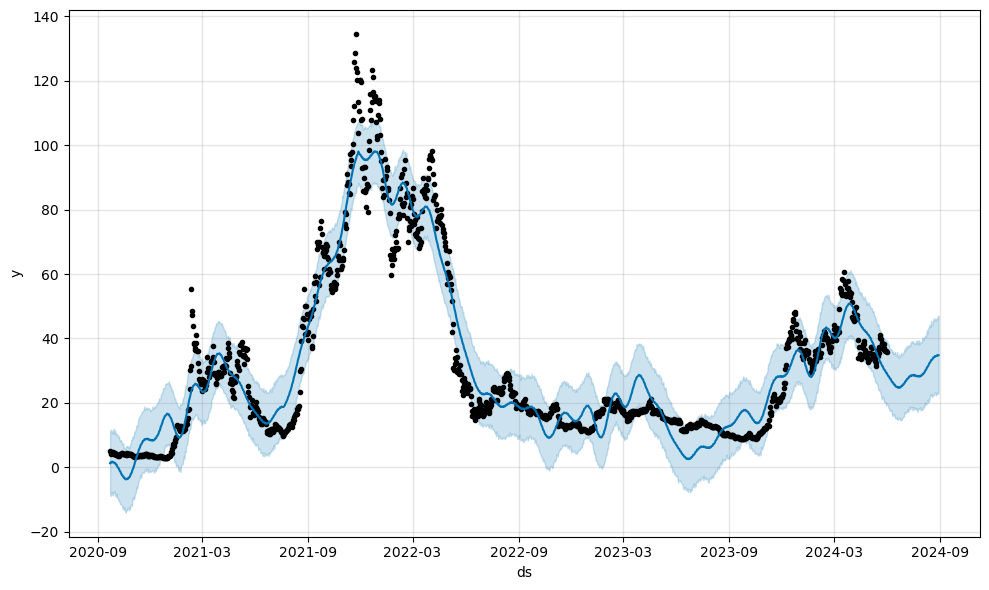

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-02,28.835971,19.632175,39.157746
2024-06-03,28.528567,19.275025,38.305009
2024-06-04,28.277407,18.409366,37.810752
2024-06-05,28.210655,18.358996,38.212452
2024-06-06,27.757146,17.585697,36.702300
...,...,...,...
2024-08-26,34.521922,22.391303,46.156295
2024-08-27,34.617707,23.223787,45.943199
2024-08-28,34.888757,23.102974,46.395358


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

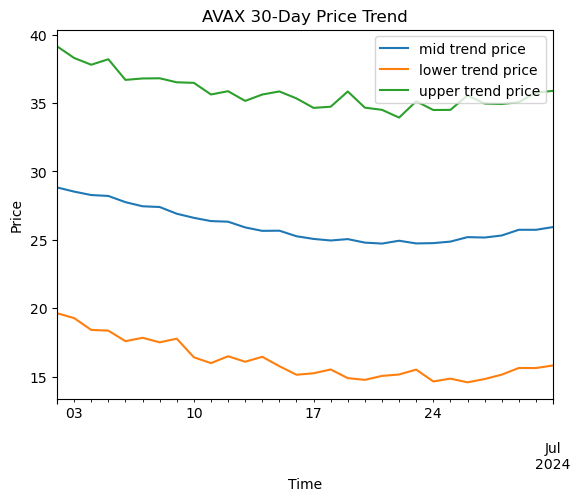

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

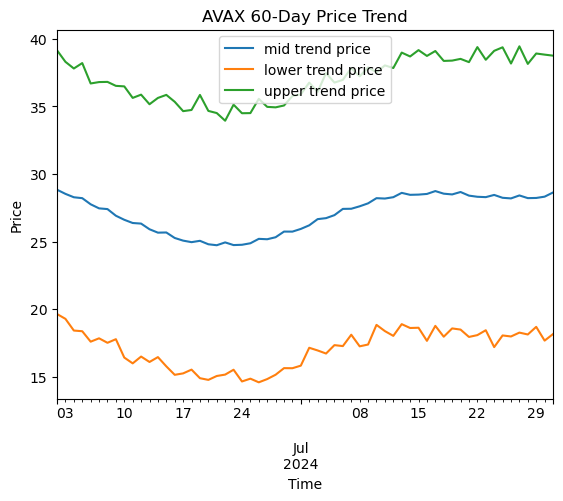

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

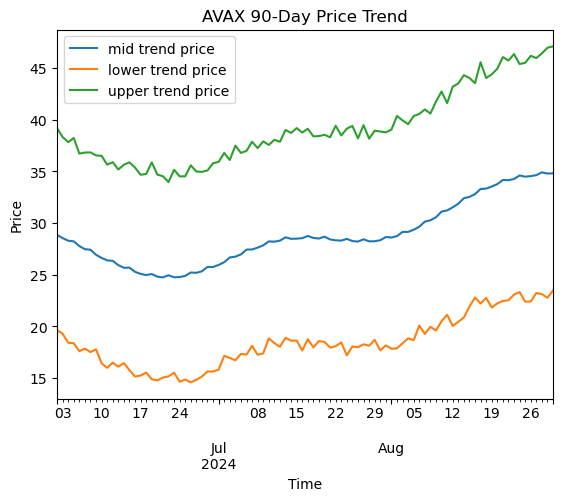

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

35.76

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

28.835971170248676

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

32.29798558512434

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

29.059566867615224

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

26.49974229083592

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

28.517777083505887

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

34.9870134542146

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.18

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.117

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.083

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

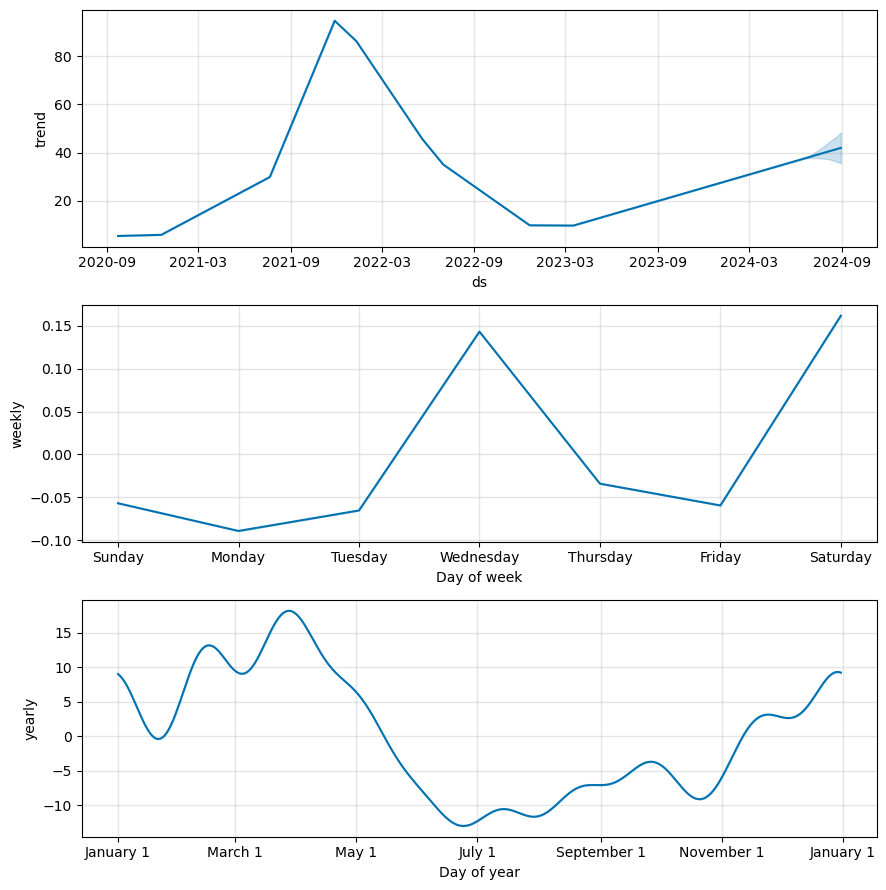

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

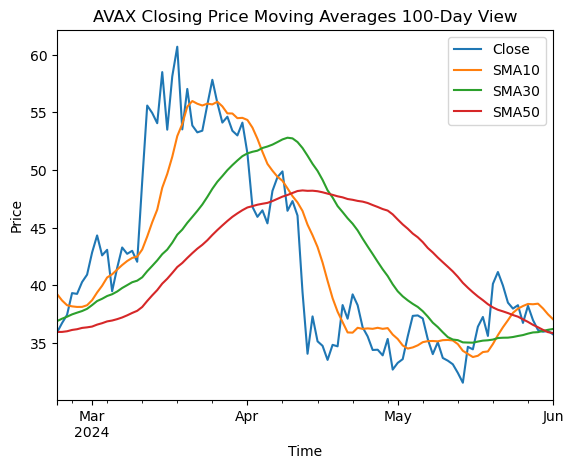

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

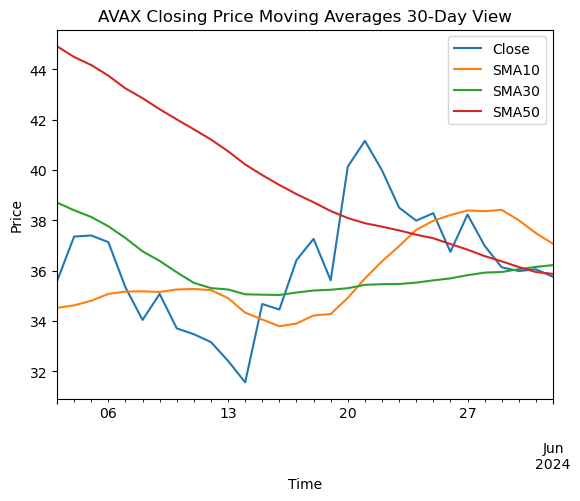

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')   
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-02
File created :  2024-06-02.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.449975,-0.10901631551481594,-0.11092059991991376,0.3509869614670582
ATOM,8.324,-0.33991694590791044,-0.3714581211536879,-0.1364866156068958
AVAX,35.76,-0.18209253217532206,-0.11091103505461575,0.08171603105696135
BNB,601.3,-0.23364934433493878,-0.1940545909823247,-0.15012398429900753
BONK,3.3e-05,0.0869994207211342,0.214013556994614,0.32649958564761183
BTC,67706.94,-0.11245843916078024,-0.06653480305698356,-0.05114734665447629
DOGE,0.1602,-0.22746720928706532,-0.2069470666925296,-0.08220738687268558
ETH,3813.2,-0.14210837945909027,-0.07466875734312517,-0.04156040932743599
PEPE,1.5e-05,0.10018396725609113,0.2973887016051089,0.48986599086615756
SHIB,2.5e-05,-0.02223985209917234,0.000567920808088429,0.016601454860916798
SOL,166.03,0.08268635494333143,0.16519430794776246,0.2856162325196754
TRX,0.112478,0.047611408863998284,0.06586311567622971,0.11520707579434442
TURBO,0.006987,-0.2950330177445859,-0.14810273834767862,0.023692560414227293
WIF,3.2756,-0.027545615271177937,-0.0076651111